In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data

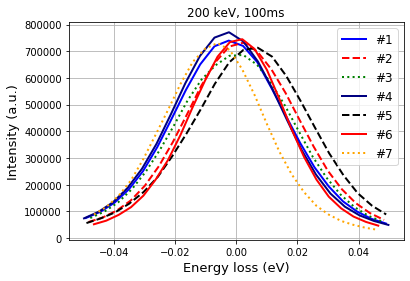

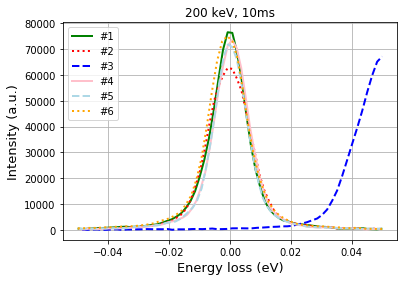


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 40


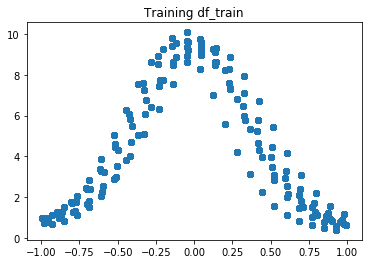

In [2]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py

seed = seednumber


### Find uncertainties on data

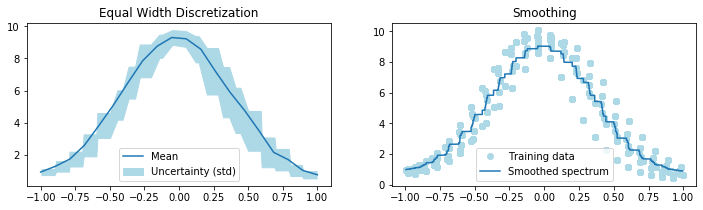

In [14]:
%run Functions.ipynb
fig = plt.gcf()

nbins = 20
minval = -1
maxval = +1

if mode == 'Mixture':
    x_train, y_train, x_val, y_val = prepare_mix_data(100)
if mode == 'Single':
    x_train, y_train = prepare_single_data()

# Create a plot of the mean & std 
plt.subplot(1, 2, 1)
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.title('Equal Width Discretization')
fig.set_size_inches(12, 5)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]

# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]


### Apply smoothing to the signal
smooth_y = np.array(smooth(df_train[:,1], 400))
smooth_y_test = np.array(smooth(df_val[:,1], 400))
plt.subplot(1,2,2)
plt.plot(df_train[:,0], df_train[:,1], 'o', color='lightblue', label='Training data')
plt.plot(df_train[:,0], smooth_y, label='Smoothed spectrum')
fig.set_size_inches(12,3)
plt.title('Smoothing')
plt.legend()
plt.show()




## Neural Network 

### Create architecture

In [15]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.relu)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    #hidden_layer_4 = tf.nn.dropout(hidden_layer_3, 0.1)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

# User defined Neural Network


### Prepare data for training

Example of one training x, shape (,2): [-0.13582373  1.        ]
Example of one training y, shape (,1): [8.57230748]


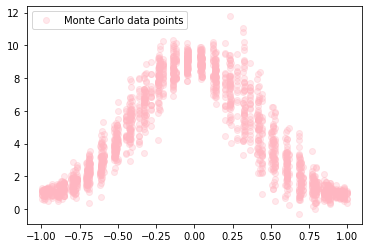

In [16]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])
N_train = len(df_train)
N_test = len(df_val)

time = 100 #[ms]

train_x_a = df_train[:,0].reshape(N_train,1)  ## Column 1 = Eloss, colum 2 = time (binary)
train_x_time = train_x_a*0 + 1
train_x = np.c_[train_x_a, train_x_time] 
train_y = smooth_y.reshape(N_train,1)  ## train_y = smooth_y in case of smoothing
train_sigma = df_train[:,2].reshape(N_train,1)
train_y +=  np.random.normal(0, train_sigma) 


test_x_a = df_val[:,0].reshape(N_test,)
test_x_time = test_x_a*0 + 1
test_x = np.c_[test_x_a, test_x_time]
test_y = smooth_y_test.reshape(N_test,1)
test_sigma = df_val[:,2].reshape(N_test,1)
test_y +=  np.random.normal(0, test_sigma)


predictions = make_model(x,1)

cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 8e-4
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(cost)

plt.plot(train_x[:,0], train_y, 'o', alpha=.3, color='lightpink', label='Monte Carlo data points')
#plt.plot(train_x[:,0], smooth_y, label='Smoothed function')
plt.legend()
plt.show

print("Example of one training x, shape (,2):", train_x[800,:])
print("Example of one training y, shape (,1):", train_y[800])

#Scaling input features to help the minimizer.
#train_scaler = StandardScaler()
#train_scaler.fit(train_x[:,0].reshape(1,-1))
#test_scaler = StandardScaler()
#test_scaler.fit(test_x[:,0].reshape(1,-1))



### Train and validate

In [17]:
training_epochs = 20000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
prev_test_cost = 100
prev_epoch=0
avg_cost = 0.0

xnew = train_x
ynew = train_y
snew = train_sigma

array_train = []
array_test = []
print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x,
                            y: train_y,
                            sigma: train_sigma
                        })
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
            array_train.append(avg_cost)
            array_test.append(test_cost)
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The session stopped because of overfitting...","red"))
            print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
            break
        
            
        elif test_cost < prev_test_cost:
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x,
                            y: train_y 
                        })
sess.close()
    


Start training on 1804 and validating on 0452 samples
Epoch: 0001 | Training cost= 57.557758331 | Validation cost= 61.555431366
Epoch: 1001 | Training cost= 1.068014860 | Validation cost= 9.227996826
Epoch: 2001 | Training cost= 1.056550503 | Validation cost= 9.368207932
Epoch: 3001 | Training cost= 1.052700996 | Validation cost= 9.410101891
Epoch: 4001 | Training cost= 1.050560474 | Validation cost= 9.444748878
Epoch: 5001 | Training cost= 1.049358130 | Validation cost= 9.468417168
Epoch: 6001 | Training cost= 1.048431873 | Validation cost= 9.482237816
Epoch: 7001 | Training cost= 1.047567129 | Validation cost= 9.489102364
Epoch: 8001 | Training cost= 1.046969533 | Validation cost= 9.494585991
Epoch: 9001 | Training cost= 1.046709776 | Validation cost= 9.501047134
Epoch: 10001 | Training cost= 1.046620131 | Validation cost= 9.504590988

 The session stopped because of overfitting...
Start overfitting at epoch: 10451 | Validation cost = 9.497164726 | Train cost= 1.046597004
Optimizatio

### Plot outputs

In [18]:
# save to csv file
from datetime import datetime
predictions_values = predictions_values.reshape(N_train,)

#foot = np.array(seednumber)
a = np.array(train_x[:,0])
b = np.array(train_y)
c = np.array(predictions_values)
d = array_train
e = array_test

now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
np.savetxt('Data/Results/%(date)s.%(seed)x(a).csv' % {"date": dt_string, "seed":seed}, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
np.savetxt('Data/Results/%(date)s.%(seed)x(b).csv' % {"date": dt_string, "seed":seed}, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')


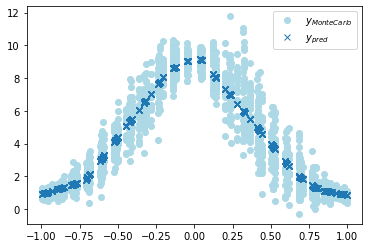

In [19]:
plt.plot(train_x[:,0], train_y, 'o', label='$y_{MonteCarlo}$', color='lightblue')
plt.plot(train_x[:,0], predictions_values, 'x', label='$y_{pred}$')
#plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
plt.show()

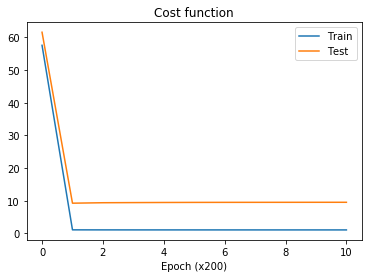

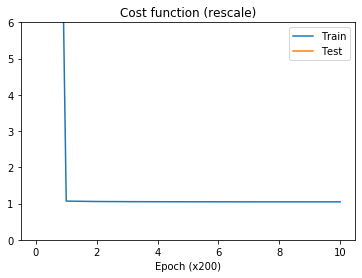

In [20]:
plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function')
plt.legend()
plt.show()

plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function (rescale)')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function (rescale)')
plt.ylim([0,6])
plt.legend()
plt.show()

